## Visualizing the FANTASTX results: applied to the CdTe-Tellurene example

Once FANTASTX has finished running, it will yield a **data_file** which contains all of the calculated objective functions, and a folder called **calcs** which contains all of the simulation outputs for every evaluated configuration. FANTASTX is also capable of connecting to a MongoDB database, which can then be processed. Here, we will demonstrate processing both the *data_file* as well as the MongoDB database.

### Processing the data file

First, let's read in the data file, and determine which models are Pareto optimal.

In [1]:
import os
from scripts.analysis import *

data_file_path = os.getcwd() + "/outputs/data_file"
cdte_tellurene_results = read_in_data_file(data_file_path, "multi")
pareto_indices, non_pareto_indices, pareto_objs, non_pareto_objs = get_nondominated_solutions(cdte_tellurene_results, [1,2])

The objective functions for these models are the: \[total energy, formation_energy, and STEM SSIM score\].

We can check Pareto optimality by looking at the pareto_indices.

In [2]:
model_one = cdte_tellurene_results[1]
print(model_one)
model_one_pareto = 1 in pareto_indices
print(f"Model 1 Pareto: {model_one_pareto}")

[-72.986951, 0.633917, 26.722139]
Model 1 Pareto: False


We can also plot this data, to visualize what the distribution of models in objective space looks like.

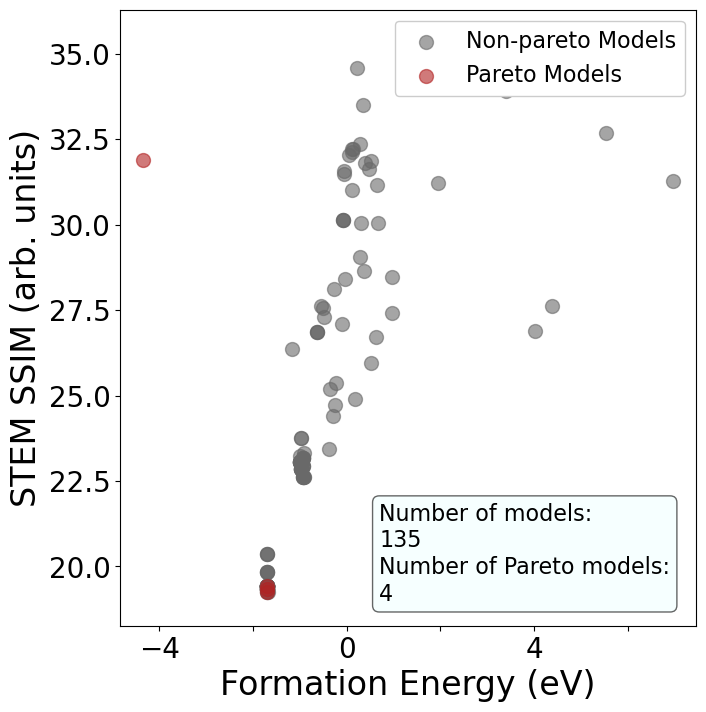

In [3]:
from matplotlib import pyplot as plt
#grab models, sort into "population" and "archive" groups
pareto_array = np.array(pareto_objs)
non_pareto_array = np.array(non_pareto_objs)

pareto_x = pareto_array[:,1]
pareto_y = pareto_array[:,2]
non_pareto_x = non_pareto_array[:,1]
non_pareto_y = non_pareto_array[:,2]
min_x = min(np.min(pareto_x), np.min(non_pareto_x)) - 0.5
max_x = max(np.max(pareto_x), np.max(non_pareto_x)) + 0.5
min_y = min(np.min(pareto_y), np.min(pareto_y)) - 1
max_y = max(np.max(non_pareto_y), np.max(non_pareto_y)) + 1

num_models = len(pareto_array) + len(non_pareto_array)
num_pareto_models = len(pareto_array)

fig, axes = plt.subplots(1, 1)
plt.subplots_adjust(left = 0.18)
fig.set_size_inches(8, 8)
axes.scatter(non_pareto_x, non_pareto_y,
             s=100, marker = "o", c = "dimgrey", alpha = 0.6, label="Non-pareto Models")
axes.scatter(pareto_x, pareto_y,
             s=100, marker="o", c="firebrick", alpha = 0.6, label="Pareto Models")
axes.set_ylabel(r"STEM SSIM (arb. units)", fontsize=24)
axes.set_xlabel(
    "Formation Energy (eV)", fontsize=24)
axes.set_xlim((min_x, max_x))
axes.set_ylim((min_y, max_y))
plt.setp(axes.get_xticklabels(), fontsize=20)
plt.setp(axes.get_yticklabels(), fontsize=20)
plt.setp(axes.get_xticklabels()[::2], visible=False)
plt.legend(fontsize=16, loc = 'upper right', framealpha = 1.0)

props = dict(boxstyle='round', facecolor='azure', alpha=0.6)
textstr = f"Number of models:\n{num_models}\nNumber of Pareto models:\n{num_pareto_models}"
axes.text(0.45, 0.2, textstr, transform=axes.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
filename = os.getcwd() + "/outputs/pareto_visualization.png"
plt.savefig(filename, format="png", dpi=300)
plt.show()

Here, we observe that for the most part, the progression of models converges to a single point, with a single outlier lying to the top left of the plot. The next step is to analyze the Pareto optimal models more closely.

In [4]:
for n, i in enumerate(pareto_indices):
    print(f"Pareto model {n}, overall model {i}: {pareto_objs[n]}")

Pareto model 0, overall model 49: [-78.459333, -1.695465, 19.422239]
Pareto model 1, overall model 46: [-77.961089, -4.340221, 31.902562]
Pareto model 2, overall model 76: [-78.459297, -1.695429, 19.345653]
Pareto model 3, overall model 138: [-78.457158, -1.69329, 19.26385]


/home/dgunruh/anaconda3/envs/condampi/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.9.10-3-g6b33d55fd-dirty is an invalid version and will not be supported in a future release
  warnings.warn(


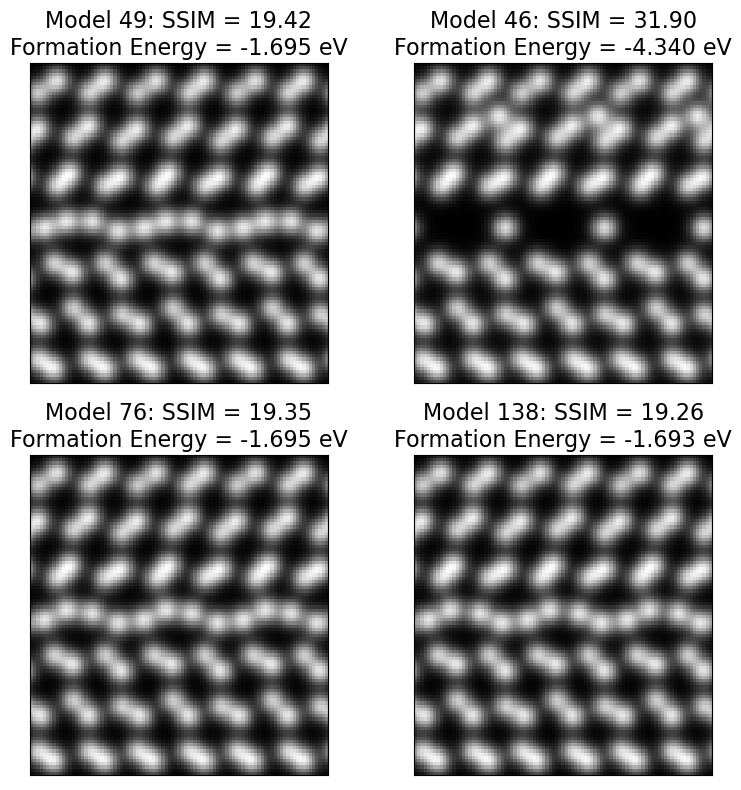

In [5]:
from ingrained.structure import Bicrystal
opt_params = [0.26, 0, 1.67]

fig, axes = plt.subplots(2, 2, figsize = (8, 8))
for n, i in enumerate(pareto_indices):
    bicrys_model = Bicrystal(poscar_file=f'outputs/calcs/{i}/relax/POSCAR_relaxed')
    # each of these cells needs to be replicated to be of the same dimensionality as the experimental image
    bicrys_model.structure.make_supercell((1,3,1))
    sim_img, __ = bicrys_model._get_image_cell(pix_size=opt_params[0],
                                               interface_width=opt_params[1],
                                               defocus=opt_params[2],
                                               view=False)
    sim_img = sim_img[32:132]
    ax = axes[n//2][n%2]
    ax.imshow(sim_img, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Model {i}: SSIM = {pareto_objs[n][2]:0.2f}\nFormation Energy = {pareto_objs[n][1]:0.3f} eV", fontsize = 16)
plt.tight_layout()

Here, we see that model 46, the model with the abnormally low formation energy, had an error where a Te atom was kicked into the upper CdTe grain. This model can be discarded out of hand.

Looking at the other 3 models, we observe that model 138, despite it's slightly better agreement with experiment than the other two models, exhibits an odd spacing between two of the Te atoms (also explaining it's slightly higher formation energy). This model can also be discarded. Visually, model 76 seems to agree the best with experiment and has the same energy as model 49, and thus we can use this model for further processing.

### Starting, connecting to, and processing the MongoDB database

Ordinarily, the MongoDB database would have been running earlier, before we began running FANTASTX. However, as we did not need to do so already, we now need to start the MongoDB database in order to connect to it. We will then connect to it, and extract the same information that we saw previously, as well as additional information that was not included in the *data_file*.

In [6]:
# %%bash
# mongod --dbpath data/db --logpath cdte_tellurene.log --fork
# ps -e | grep 'mongod'

In [7]:
from pymongo import MongoClient
def connect_to_mongodb(host=None, port=None, username=None, password=None):
    return MongoClient(
        host,
        port,
        username,
        password
    )

config = {
    "client": {
        "username": None,
        "password": None,
        "host": "127.0.0.1",
        "port": 27017
    },
}
client = connect_to_mongodb(**config["client"])

In [9]:
db = client['cdte_tellurene']
col = db['models']
print(f"Sample database entry: {list(db.models.find({'_id': 1}))[0]}")

Sample database entry: {'_id': 1, 'total_energy': -72.986951, 'formation_energy': 0.633917, 'exp_sim_1': 26.722139, 'paretoOptimal': False, 'inPopulation': False, 'inArchive': False}


In [10]:
import pandas as pd
df = pd.DataFrame(list(db.models.find()))
pareto_optimal_df = df[df['paretoOptimal']]
non_pareto_optimal_df = df[df['paretoOptimal'] == False]
population_df = df[df['inPopulation']]
non_population_df = df[df['inPopulation'] == False]
archive_df = df[df['inArchive']]

Now, we can perform the same operation that we did above, on this data extracted from the database

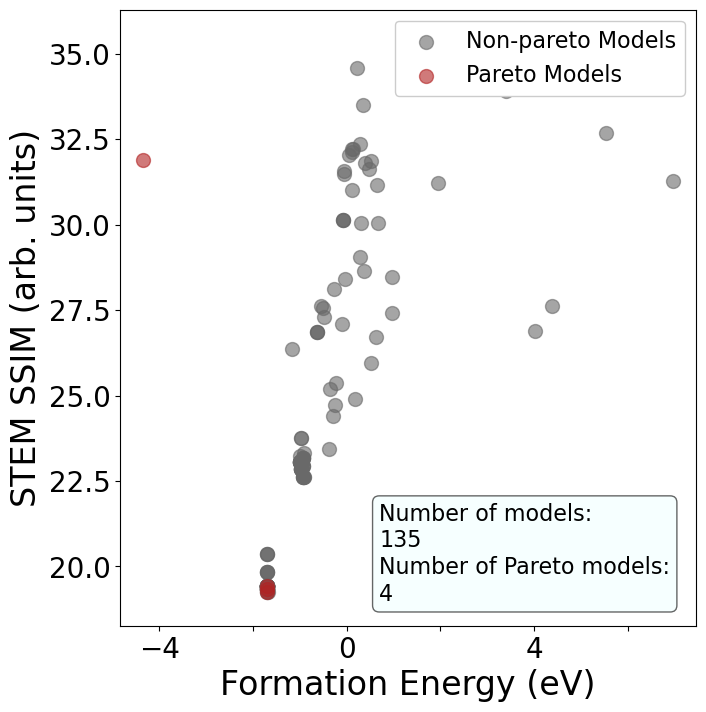

In [11]:
min_x = min(df['formation_energy']) - 0.5
max_x = max(df['formation_energy']) + 0.5
min_y = min(df['exp_sim_1']) - 1
max_y = max(df['exp_sim_1']) + 1
num_models = len(df)
num_pareto_models = len(pareto_optimal_df)

fig, axes = plt.subplots(1, 1)
plt.subplots_adjust(left = 0.18)
fig.set_size_inches(8, 8)
axes.scatter('formation_energy', 'exp_sim_1', data = non_pareto_optimal_df,
             s=100, marker = "o", c = "dimgrey", alpha = 0.6, label="Non-pareto Models")
axes.scatter('formation_energy', 'exp_sim_1', data = pareto_optimal_df,
             s=100, marker = "o", c = "firebrick", alpha = 0.6, label="Pareto Models")
axes.set_ylabel(r"STEM SSIM (arb. units)", fontsize=24)
axes.set_xlabel(
    "Formation Energy (eV)", fontsize=24)
axes.set_xlim((min_x, max_x))
axes.set_ylim((min_y, max_y))
plt.setp(axes.get_xticklabels(), fontsize=20)
plt.setp(axes.get_yticklabels(), fontsize=20)
plt.setp(axes.get_xticklabels()[::2], visible=False)
plt.legend(fontsize=16, loc = 'upper right', framealpha = 1.0)

props = dict(boxstyle='round', facecolor='azure', alpha=0.6)
textstr = f"Number of models:\n{num_models}\nNumber of Pareto models:\n{num_pareto_models}"
axes.text(0.45, 0.2, textstr, transform=axes.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
filename = os.getcwd() + "/outputs/pandas_pareto_visualization.png"
plt.savefig(filename, format="png", dpi=300)
plt.show()

We can also visualize the active model population as relevant to the selection algorithm that we are using to choose parents. In this case, this data comes from a FANTASTX search which employed the $\epsilon$-MOEA selection algorithm. This algorithm, documented in [this]() paper, is organized as follows.

Two co-evolving pools of models are maintained. One of these pools is the evolutionary population, which initially contains the entire starting set of models and is kept fixed at a constant size. The other is an epsilon-discretized archive, which is allowed to vary in size as it consists of the epsilon-discretized set of non-dominated models of the population. New models are tested for addition to each pool, as follows:

1. Beginning with the population, the model is rejected from addition if it is dominated by all models in the pool. If it dominates any models, then it replaces one of them at random. If it otherwise is non-dominated with all models, then it similarly replaces one of them at random. 

2. When adding models to the archive, model acceptance and replacement similarly hinges on non-dominance relations. However, the archive is discretized in objective space by an epsilon grid. 

For archive purposes, the objective values of each model are represented as:
$$
\begin{equation}
X_i=\begin{cases}
\lfloor(x_i - x^{min}_i)/\epsilon_i\rfloor, &\text{when minimizing $x_i$}\\
\lceil(x_i - x^{min}_i)/\epsilon_i\rceil, &\text{when maximizing $x_i$}
\end{cases}
\end{equation}
$$
where $x_i$ is the actual objective value, $x^\textrm{min}_i$ is the minimum possible objective value, and $\epsilon_i$ is the discretizing value chosen by the user for that objective function.

Only one model is allowed to live in each $\epsilon$-box in the archive. If two models have the same objective functions $X_i$, then only the model which is closest to the target corner (minimizing or maximizing each objective as desired) of the $\epsilon$-box is kept in the archive. It should be noted that the model which is not kept would still be guaranteed to be added to the population, as the archive consists of all non-dominated population models and the population does not use such $\epsilon$ discretization. 


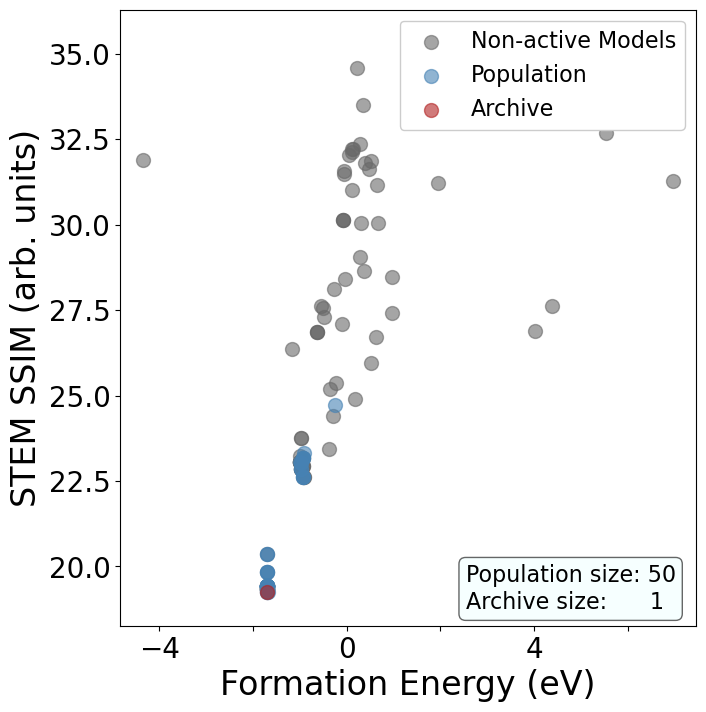

In [12]:
population_size = len(population_df)
archive_size = len(archive_df)

fig, axes = plt.subplots(1, 1)
plt.subplots_adjust(left = 0.18)
fig.set_size_inches(8, 8)
axes.scatter('formation_energy', 'exp_sim_1', data = non_population_df,
             s=100, marker = "o", c = "dimgrey", alpha = 0.6, label="Non-active Models")
axes.scatter('formation_energy', 'exp_sim_1', data = population_df,
             s=100, marker = "o", c = "steelblue", alpha = 0.6, label="Population")
axes.scatter('formation_energy', 'exp_sim_1', data = archive_df,
             s=100, marker = "o", c = "firebrick", alpha = 0.6, label="Archive")
axes.set_ylabel(r"STEM SSIM (arb. units)", fontsize=24)
axes.set_xlabel(
    "Formation Energy (eV)", fontsize=24)
axes.set_xlim((min_x, max_x))
axes.set_ylim((min_y, max_y))
plt.setp(axes.get_xticklabels(), fontsize=20)
plt.setp(axes.get_yticklabels(), fontsize=20)
plt.setp(axes.get_xticklabels()[::2], visible=False)
plt.legend(fontsize=16, loc = 'upper right', framealpha = 1.0)

props = dict(boxstyle='round', facecolor='azure', alpha=0.6)
textstr = f"Population size: {population_size}\nArchive size:      {archive_size}"
axes.text(0.6, 0.1, textstr, transform=axes.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
filename = os.getcwd() + "/outputs/pandas_emoea_visualization.png"
plt.savefig(filename, format="png", dpi=300)
plt.show()

Here, as expected, the active population size is 50 models, the number of models that we told FANTASTX to maintain in the population. We also see that the archive only contains a single model. This is unsurprising, as the pareto optimal models in that quadrant all occupy a single $\epsilon$-box, and FANTASTX has the added change to the $\epsilon$-MOEA algorithm that models can only live in the archive until they produce a finite number of offspring. The other Pareto model already produced all possible children (despite it's unphysicality!).